In [1]:
from collect_data import *
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
audio_path = os.path.join(meg_path, 'collect_data/audio')
megsp_list = os.listdir(megsp_path)
audio_list = os.listdir(audio_path)

megsp_list_session_0 = [f for f in megsp_list if f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.split('_')[1] == '1']

In [3]:
def split_tensor(tensor, train_ratio=0.7, val_ratio=0.1):
    total_samples = tensor.size(0)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    train_tensor = tensor[:train_size]
    val_tensor = tensor[train_size:train_size + val_size]
    test_tensor = tensor[train_size + val_size:]
    return train_tensor, val_tensor, test_tensor


def get_splitted_tensor(file_list, path):
    tensor_list_train = []
    tensor_list_valid = []
    tensor_list_test = []
    for file_name in file_list:
        file_path = os.path.join(path, file_name)
        tensor = torch.load(file_path)
        train_tensor, val_tensor, test_tensor = split_tensor(tensor)
        tensor_list_train.append(train_tensor)
        tensor_list_valid.append(val_tensor)
        tensor_list_test.append(test_tensor)
    tensor_train = torch.cat(tensor_list_train, dim=0)
    tensor_valid = torch.cat(tensor_list_valid, dim=0)
    tensor_test = torch.cat(tensor_list_test, dim=0)
    return tensor_train, tensor_valid, tensor_test



In [4]:
audio_tensor_train, audio_tensor_valid, audio_tensor_test = get_splitted_tensor(audio_list, audio_path)
audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)


DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 257, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 257, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 257, 376])
DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        """
        """
        assert X.size(0) == Y.size(0), "The number of input and output samples must be the same"
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

train_dataset = CustomDataset(audio_tensor_train, meg_tensor_train)
valid_dataset = CustomDataset(audio_tensor_valid, meg_tensor_valid)
test_dataset = CustomDataset(audio_tensor_test, meg_tensor_test)

# batch_size = 32  # --> da scegliere
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



### Single Ridge Regression

In [5]:
X_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
y_train = meg_tensor_train.reshape(meg_tensor_train.shape[0], -1)
X_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)
y_test = meg_tensor_test.reshape(meg_tensor_test.shape[0], -1)
X_valid = audio_tensor_valid.reshape(audio_tensor_valid.shape[0], -1)
y_valid = meg_tensor_valid.reshape(meg_tensor_valid.shape[0], -1)

ridge = Ridge(alpha=5000, max_iter=10000)
ridge.fit(X_train, y_train)

pred_test_latent = ridge.predict(X_test)
train_predicted = ridge.predict(X_train)
val_predicted = ridge.predict(X_valid)

print("rmse", mean_squared_error(y_train, train_predicted))
print("rmse", mean_squared_error(y_valid, val_predicted))
print("rmse", mean_squared_error(y_test, pred_test_latent))


rmse 28.434341306011174
rmse 68.27646497559086
rmse 70.31384085931612


In [7]:
y_test_flat = y_test.reshape(-1)
ridge_predictions_flat = pred_test_latent.reshape(-1)
correlation_matrix = np.corrcoef(y_test_flat, ridge_predictions_flat)
print("Correlation matrix between actual and predicted:")
print(correlation_matrix)

Correlation matrix between actual and predicted:
[[1.         0.50532865]
 [0.50532865 1.        ]]


In [19]:
pred_test_latent_reshape = torch.tensor(pred_test_latent).reshape(-1, 208, 16, 26)

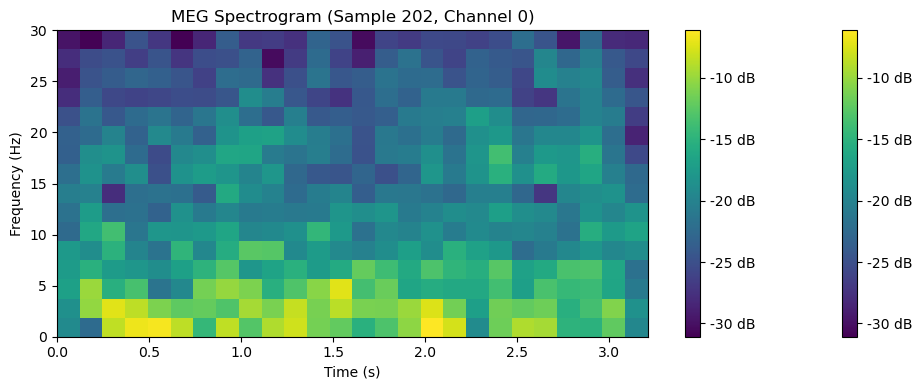

In [41]:
plot_spectrogram(pred_test_latent_reshape, sampling_meg, 202, 0)

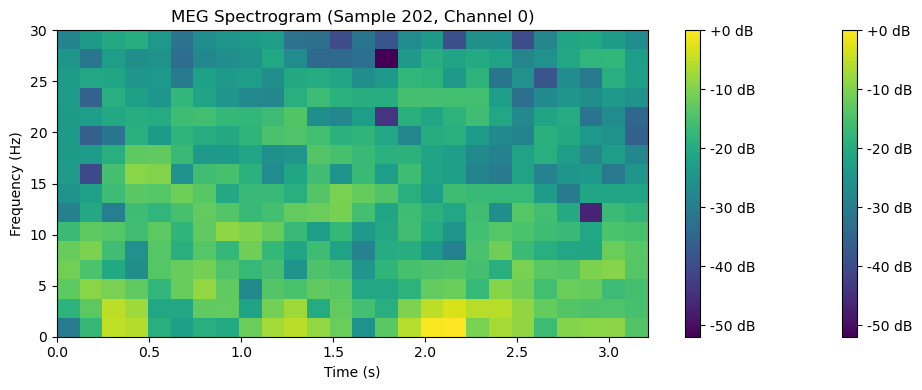

In [42]:
plot_spectrogram(meg_tensor_test, sampling_meg, 202, 0)

### Ridge Regression for every MEG channel

In [5]:
pred_target = []
mse_scores = []
real_target = []
audio_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
audio_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)

for channel in tqdm(range(num_channel)):    # 10 canali --> tempo +/- 12 minuti
    y_train = meg_tensor_train[:, channel, :, :].reshape(meg_tensor_train.shape[0], -1)
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)

    model = Ridge(alpha=5000, max_iter=2000)
    model.fit(audio_train, y_train)

    y_pred = model.predict(audio_test)
    mse = mean_squared_error(y_test, y_pred)
    pred_target.append(y_pred)
    real_target.append(y_test)
    mse_scores.append(mse)

    


100%|██████████| 208/208 [3:44:02<00:00, 64.63s/it]  


In [13]:
# save_pred_target = os.path.join(meg_path, 'collect_data/meg_prediction_ridge.pt')
# torch.save(torch.tensor(pred_target), save_pred_target)
# save_mse = os.path.join(meg_path, 'collect_data/meg_mse_ridge.pt')
# torch.save(torch.tensor(mse_scores), save_mse)

In [5]:
real_target = []
for channel in range(num_channel):
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)
    real_target.append(y_test)

pred_mse_scores = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge.pt'))
pred_meg_y = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge.pt'))
print("PREDICTION_SHAPE:", pred_meg_y.shape)

PREDICTION_SHAPE: torch.Size([208, 3480, 416])


In [6]:
correlations = np.array([np.corrcoef(real_target[i], pred_meg_y[i])[0, 1] for i in range(num_channel)])
print("DIAG_CORRELATION_MATRIX", correlations)
print("MSE_SCORES", pred_mse_scores.tolist())


DIAG_CORRELATION_MATRIX [0.44687414 0.38193695 0.15102686 0.37346252 0.38620107 0.18739323
 0.2621355  0.33459648 0.42631936 0.24307491 0.31513486 0.43078534
 0.51346364 0.38469357 0.34757442 0.22370144 0.52735921 0.33150846
 0.26497303 0.5038545  0.31064132 0.38748161 0.37840857 0.47729897
 0.3466337  0.44346605 0.43302488 0.36690972 0.41160963 0.44343872
 0.55546912 0.18003945 0.52949312 0.30446504 0.49563585 0.46965793
 0.5238229  0.49788574 0.47461802 0.48416812 0.44752585 0.27929566
 0.42802519 0.4353812  0.35027737 0.16427001 0.39857906 0.41122491
 0.49906795 0.57045929 0.45420744 0.47826167 0.59620553 0.3700844
 0.4797922  0.41630026 0.54132602 0.5232327  0.56051816 0.41181102
 0.57784775 0.55625074 0.45933961 0.34983073 0.52532543 0.5799275
 0.31233193 0.43757619 0.41696369 0.55177796 0.4772894  0.33663973
 0.52937101 0.43198374 0.52372959 0.5222248  0.53861199 0.42435252
 0.20356156 0.51465786 0.31310322 0.48894936 0.51679934 0.52983036
 0.49268814 0.45736332 0.51075849 0.5104

Extracting SQD Parameters from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:47: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


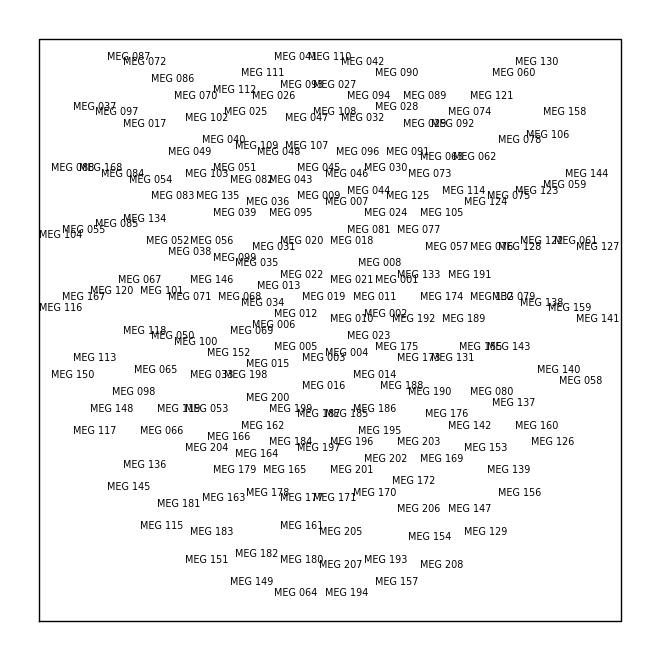

Figure(640x640)


In [7]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())


(208, 2)
(208,)


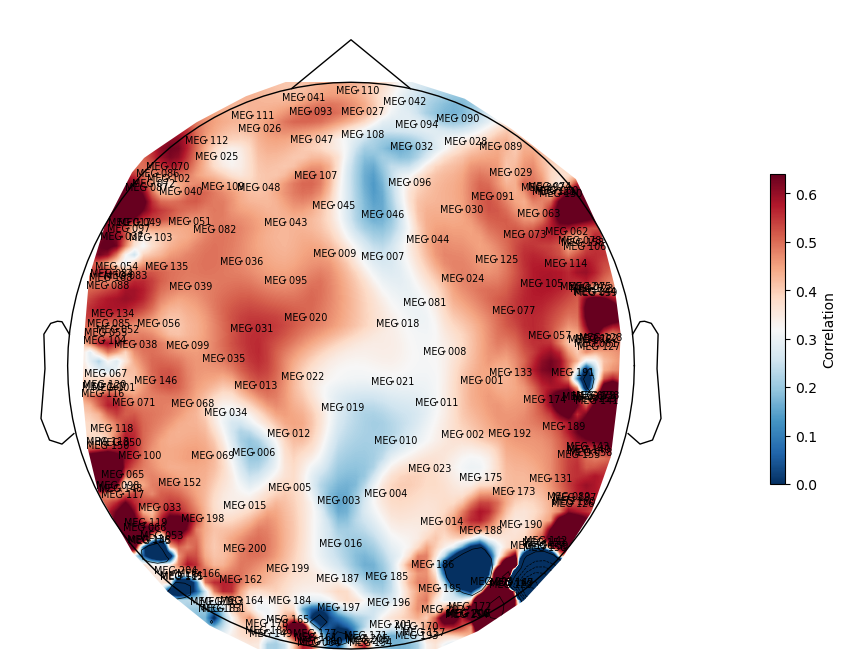

In [16]:
meg_indices = mne.pick_types(raw.info, meg=True)
meg_channel_positions = np.array([raw.info['chs'][i]['loc'][:2] for i in meg_indices])
print(meg_channel_positions.shape)

correlations = np.array(correlations).reshape(-1)
print(correlations.shape)
fig, ax = plt.subplots()
topomap = mne.viz.plot_topomap(correlations, meg_channel_positions, ch_type='meg',
                               names=raw.info['ch_names'], sphere=0.13,
                               image_interp='cubic', extrapolate='local',
                               border='mean', size=8.5, cmap='RdBu_r', axes=ax, show=False)
cbar = plt.colorbar(topomap[0], ax=ax, fraction=0.02, pad=0.1)
cbar.set_label('Correlation')
fig.set_size_inches(10, 8)  
plt.show()